<a href="https://colab.research.google.com/github/PacktPublishing/Machine-Learning-for-Time-Series-with-Python/blob/master/chapter5/Forecasting.ipynb" target="_parent\"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install statsmodels yfinance pmdarima arch

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import pandas as pd

plt.style.use('seaborn-v0_8-whitegrid')

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = "17"
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markersize'] = 1
# plt.style.use('.matplotlibrc')

In [3]:
from datetime import datetime
import yfinance as yf
  
start_date = datetime(2005, 1, 1)
end_date = datetime(2021, 1, 1)

df = yf.download(
    'SPY',
    start=start_date,
    end = end_date
)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


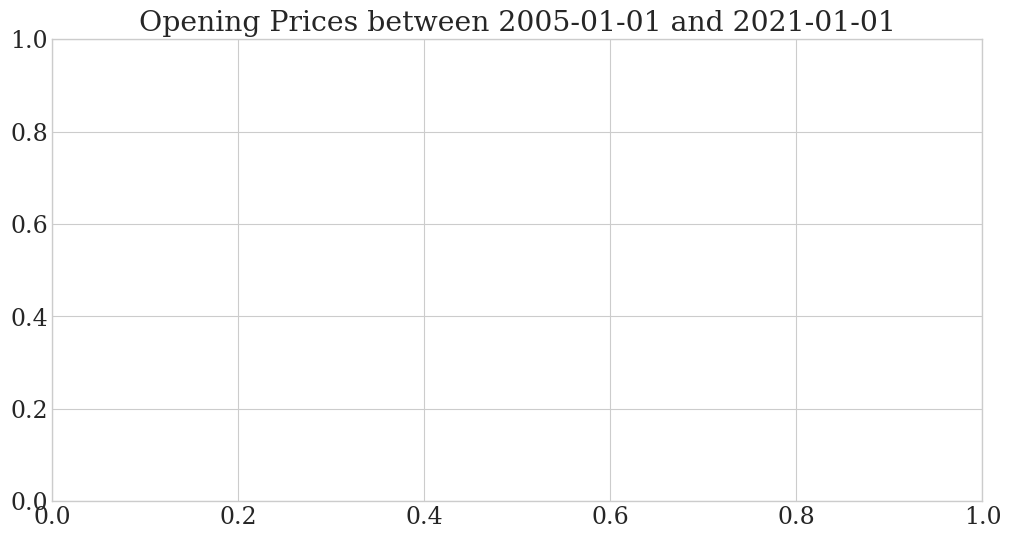

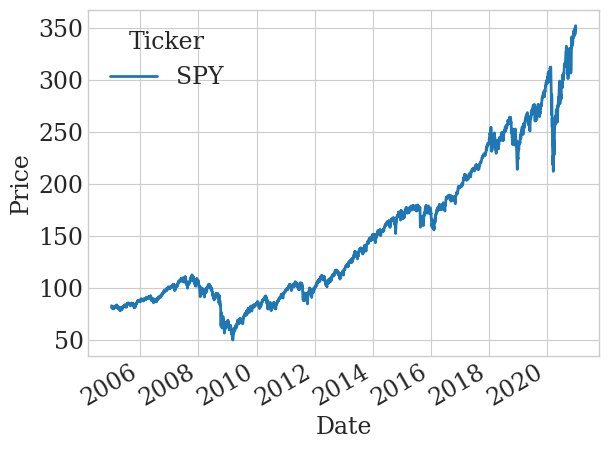

In [4]:
import matplotlib.pyplot as plt

# Optionnel : définir une police générique pour éviter les erreurs
plt.rcParams["font.family"] = ["serif"]

plt.figure(figsize=(12, 6))
plt.title(f"Opening Prices between {start_date.date().isoformat()} and {end_date.date().isoformat()}")
df['Open'].plot()
plt.ylabel('Price')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.show()


In [5]:
df.head()

Price,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Date,,,,,
2005-01-03,82.316681,83.315702,82.042975,83.178847,55748000
2005-01-04,81.310791,82.480877,81.043929,82.426135,69167600
2005-01-05,80.749718,81.598201,80.742874,81.249226,65667300
2005-01-06,81.160278,81.529780,80.920788,81.043955,47814700
2005-01-07,81.043961,81.584528,80.831836,81.406618,55847700


In [6]:
df1 = df.reset_index().resample('W', on="Date")['Open'].mean()

<Axes: >

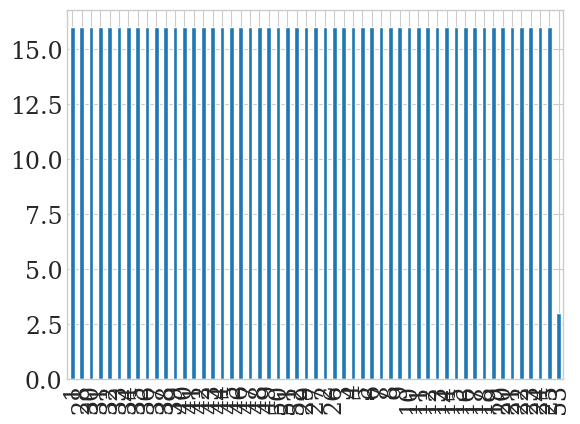

In [7]:
# some years have 53 weeks. We can't handle that, so we'll get rid of the 53rd week.
df1.index.isocalendar().week.value_counts().plot.bar()

<Axes: >

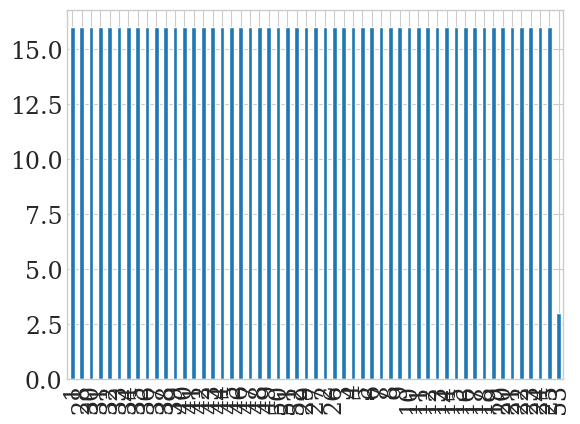

In [8]:
# final check: 
# final check:
df1.index.isocalendar().week.value_counts().plot.bar()

In [9]:
df1 = df1[~df1.isnull()]

In [10]:
# let's fix the frequency:
df1 = df1.asfreq('W').fillna(method='ffill')

In [11]:
df1.index.freq

<Week: weekday=6>

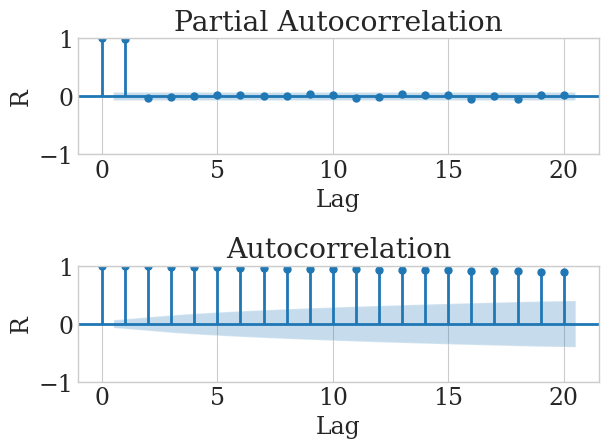

In [12]:
import statsmodels.api as sm

fig, axs = plt.subplots(2)
sm.graphics.tsa.plot_pacf(df1, lags=20, ax=axs[0])
axs[0].set_ylabel('R')
axs[0].set_xlabel('Lag')
sm.graphics.tsa.plot_acf(df1, lags=20, ax=axs[1]);
axs[1].set_ylabel('R')
axs[1].set_xlabel('Lag')
fig.tight_layout()

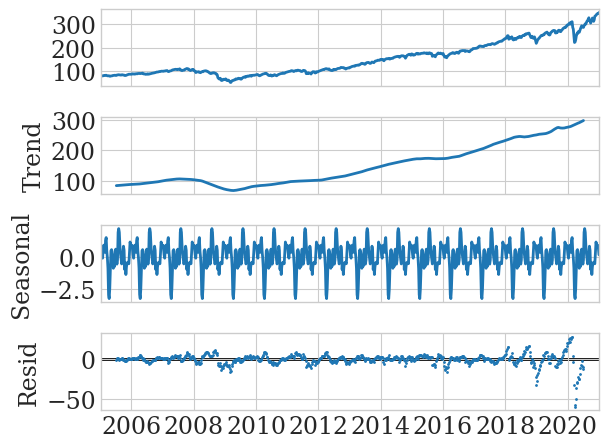

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df1, model='additive', period=52)
result.plot();

# Finding a value for d

We are using the ARCH package which has more convenient versions of both the ADF and the KPSS tests.

In [14]:
from arch.unitroot import KPSS, ADF

ADF(df1)

Test Statistic,1.989
P-value,0.999
Lags,9


In [15]:
from pmdarima.arima.utils import ndiffs

# ADF Test:
ndiffs(df1, test='adf')  # 1; same values for the KPSS and the PP test

1

In [16]:
# what happens if we forget differencing?
# We get a helful warning: 'Non-stationary starting autoregressive parameters'
mod = sm.tsa.arima.ARIMA(endog=df1, order=(1, 0, 0))
res = mod.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                    SPY   No. Observations:                  835
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -2150.274
Date:                Sat, 31 May 2025   AIC                           4306.548
Time:                        09:27:20   BIC                           4320.731
Sample:                    01-09-2005   HQIC                          4311.986
                         - 01-03-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        151.5119    569.665      0.266      0.790    -965.011    1268.035
ar.L1          0.9997      0.001    707.928      0.000       0.997       1.003
sigma2        10.0084      0.150     66.652      0.0

/root/miniconda3/envs/TimeSeries/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [17]:
# let's try again and this time, we'll take into account the seasonality:
from statsmodels.tsa.forecasting.stl import STLForecast

mod = STLForecast(df1, sm.tsa.arima.ARIMA, model_kwargs=dict(order=(1, 1, 0), trend="t"))
res = mod.fit().model_result
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  835
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1844.800
Date:                Sat, 31 May 2025   AIC                           3695.600
Time:                        09:27:20   BIC                           3709.779
Sample:                    01-09-2005   HQIC                          3701.036
                         - 01-03-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2990      0.104      2.889      0.004       0.096       0.502
ar.L1          0.2586      0.021     12.274      0.000       0.217       0.300
sigma2         4.8842      0.130     37.621      0.0

AttributeError: 'Legend' object has no attribute 'legendHandles'

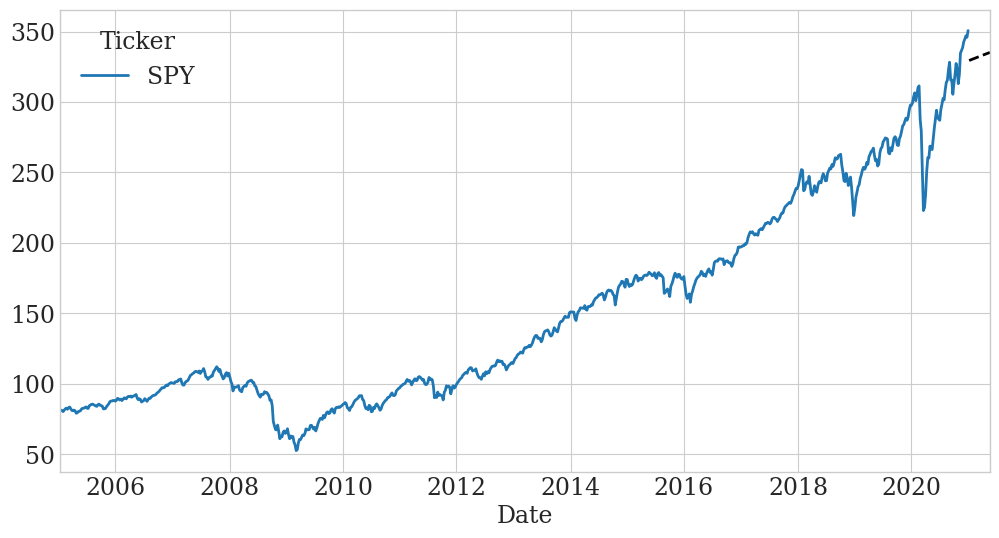

In [18]:
import matplotlib.pyplot as plt

STEPS = 20
forecasts_df = res.get_forecast(steps=STEPS).summary_frame()

fig, ax = plt.subplots(figsize=(12, 6))

# tracer la série d'origine
if isinstance(df1, pd.DataFrame):
    df1.plot(ax=ax)
elif isinstance(df1, pd.Series):
    df1.plot(ax=ax)
else:
    raise TypeError("df1 doit être une Series ou un DataFrame Pandas.")

# tracer la prédiction
forecasts_df['mean'].plot(ax=ax, style='k--')

# ajouter l'intervalle de confiance
ax.fill_between(
    forecasts_df.index,
    forecasts_df['mean_ci_lower'],
    forecasts_df['mean_ci_upper'],
    color='k',
    alpha=0.1
)

ax.set_ylabel('SPY')
ax.legend()
plt.show()


In [30]:
forecasts = []
qs = []
for q in range(0, 30, 10):
    mod = STLForecast(df1, sm.tsa.arima.ARIMA, model_kwargs=dict(order=(0, 1, q), trend="t"))
    res = mod.fit().model_result
    print(f"aic ({q}): {res.aic}")
    forecasts.append(
            res.get_forecast(steps=STEPS).summary_frame()['mean']
        )
    qs.append(q)

forecasts_df = pd.concat(forecasts, axis=1)
forecasts_df.columns = qs

aic (0): 3751.3859977779316
aic (10): 3696.7132114091423
aic (20): 3702.4035466660443


<Axes: xlabel='Date', ylabel='SPY'>

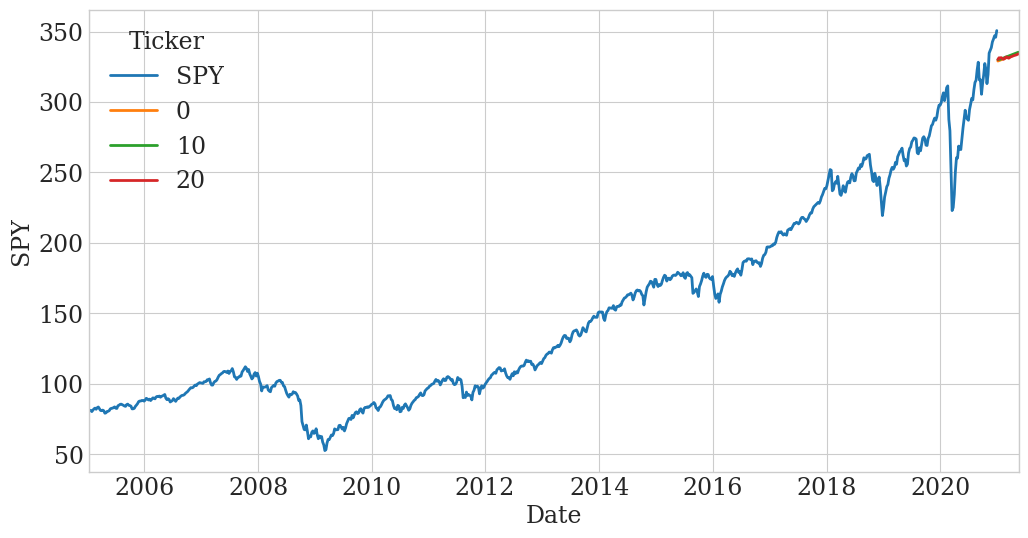

In [31]:
# plotting the three forecasts:
ax = df1.plot(figsize=(12, 6))
plt.ylabel('SPY')
forecasts_df.plot(ax=ax)

In [32]:
mod = sm.tsa.ExponentialSmoothing(
        endog=df1, trend='add', seasonal_periods=52, use_boxcox=True, initialization_method="heuristic"
    )
res = mod.fit()
print(res.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                      SPY   No. Observations:                  835
Model:             ExponentialSmoothing   SSE                           8255.823
Optimized:                         True   AIC                           1921.187
Trend:                         Additive   BIC                           1940.097
Seasonal:                          None   AICC                          1921.289
Seasonal Periods:                  None   Date:                 Fri, 30 May 2025
Box-Cox:                           True   Time:                         10:58:45
Box-Cox Coeff.:                -0.37694                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            1.0000000                alpha                 True
smoothing_trend            0.00483

<Axes: xlabel='Date', ylabel='SPY'>

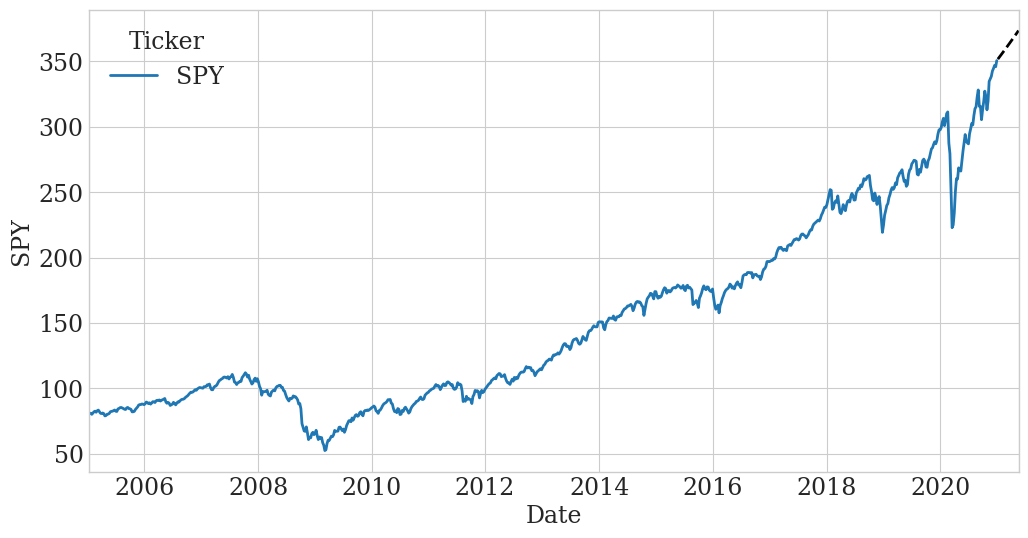

In [33]:
forecasts = pd.Series(res.forecast(steps=STEPS))
ax = df1.plot(figsize=(12, 6))
plt.ylabel('SPY')
forecasts.plot(style='k--')

<Axes: xlabel='Date', ylabel='SPY'>

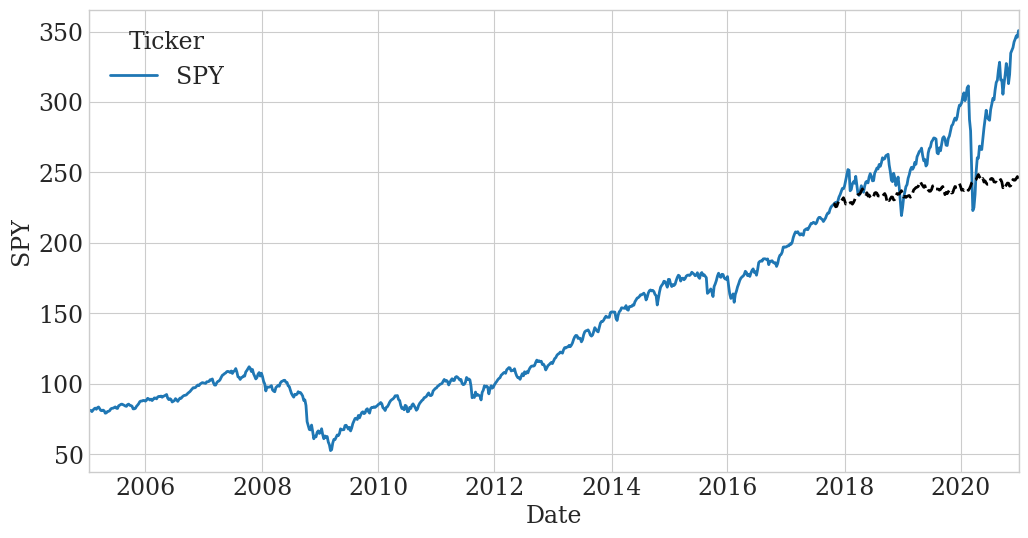

In [34]:
from statsmodels.tsa.forecasting.theta import ThetaModel

train_length = int(len(df1) * 0.8)
tm = ThetaModel(df1[:train_length], method="auto", deseasonalize=True)
res = tm.fit()
forecasts = res.forecast(steps=len(df1)-train_length)
ax = df1.plot(figsize=(12, 6))
plt.ylabel('SPY')
forecasts.plot(style='k--')

In [35]:
from sklearn import metrics

metrics.mean_squared_error(forecasts, df1[train_length:], squared=False)

41.5876909560655